In [1]:
import cmasher as cmr
import janitor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(
    context="notebook", font_scale=1.5, style="whitegrid", palette="gray"
)  #  Darkgrid Whitegrid Dark White Ticks

In [2]:
# Read in 100 random sample
df_random_sample = (
    pd.read_csv("../input/random_sample.csv")
    .assign(slug=lambda df: df["github"].str.replace("https://github.com/", ""))
    .assign(slug=lambda df: df["slug"].apply(lambda x: x[:-1] if x.endswith("/") else x))
    .assign(slug=lambda df: df["slug"].str.lower().str.strip())
    .assign(fileslug=lambda df: df["slug"].str.replace("/", "_"))
    .assign(treated=1)
    # Assign the two types
    .assign(boughtstars=lambda df: (df.index < 25).astype(int))
    .assign(treated2=lambda df: df["boughtstars"] + df["treated"])
)
df_random_sample.head(3)

,pkg,return_code,github_url,homepage,earliest_release,gh_url_check,github,pypi,label,slug,fileslug,treated,boughtstars,treated2
0,bird-ospf-link-db-parser,200.0,https://github.com/Andrew-Dickinson/bird-ospf-...,NaN,2023-04-29T07:23:44,1.0,https://github.com/Andrew-Dickinson/bird-ospf-...,https://pypi.org/project/bird-ospf-link-db-par...,bird-ospf-link-db-parser\r\nhttps://github.com...,andrew-dickinson/bird-ospf-link-db-parser,andrew-dickinson_bird-ospf-link-db-parser,1,1,2
1,asciicli,200.0,https://github.com/mrq-andras/asciicli,https://github.com/mrq-andras/asciicli,2023-04-28T07:22:55,1.0,https://github.com/mrq-andras/asciicli,https://pypi.org/project/asciicli/#history,asciicli\r\nhttps://github.com/mrq-andras/asci...,mrq-andras/asciicli,mrq-andras_asciicli,1,1,2
2,bdpotentiometer,200.0,https://github.com/bond-anton/BDPotentiometer,https://github.com/bond-anton/BDPotentiometer,2023-04-27T06:35:18,1.0,https://github.com/bond-anton/BDPotentiometer,https://pypi.org/project/bdpotentiometer/#history,bdpotentiometer\r\nhttps://github.com/bond-ant...,bond-anton/bdpotentiometer,bond-anton_bdpotentiometer,1,1,2


In [4]:
import pandas as pd
pd.read_csv("../input/repo_stars_timeseries.csv")

,slug,date,stars
0,0riion_py-sls-lambda-toolkit,2023-05-09,0
1,0riion_py-sls-lambda-toolkit,2023-05-10,0
2,0riion_py-sls-lambda-toolkit,2023-05-11,0
3,0riion_py-sls-lambda-toolkit,2023-05-12,0
4,0riion_py-sls-lambda-toolkit,2023-05-13,25
...,...,...,...
11647,zjupgx_diverge,2023-05-24,0
11648,zjupgx_diverge,2023-05-25,0
11649,zjupgx_diverge,2023-05-26,0
11650,zjupgx_diverge,2023-05-27,0


In [3]:
df = (
    pd.read_csv("../output/repo_stars_timeseries.csv")
    .rename_column("slug", "fileslug")
    # Normalize fileslug string to lowercase before merge
    .assign(fileslug=lambda df: df["fileslug"].str.lower().str.strip())
    .merge(
        df_random_sample.select_columns("fileslug", "treated", "boughtstars", "treated2"),
        how="left",
        on="fileslug",
        validate="m:1",
        indicator=True,
    )
    .assign(treated=lambda df: df["treated"].fillna(0).apply(int))
    .assign(boughtstars=lambda df: df["boughtstars"].fillna(0).apply(int))
    .assign(treated2=lambda df: df["treated2"].fillna(0).apply(int))
    .assign(date=lambda df: pd.to_datetime(df["date"]))
)
# Assert that 100 repos are assigned as treated
assert 100 == len(df.drop_duplicates("fileslug").query("treated==1"))
df

,fileslug,date,user,repo,stars,treated,boughtstars,treated2,_merge
0,0riion_py-sls-lambda-toolkit,2023-05-09,0riion,py-sls-lambda-toolkit,0,1,1,2,both
1,0riion_py-sls-lambda-toolkit,2023-05-10,0riion,py-sls-lambda-toolkit,0,1,1,2,both
2,0riion_py-sls-lambda-toolkit,2023-05-11,0riion,py-sls-lambda-toolkit,0,1,1,2,both
3,0riion_py-sls-lambda-toolkit,2023-05-12,0riion,py-sls-lambda-toolkit,0,1,1,2,both
4,0riion_py-sls-lambda-toolkit,2023-05-13,0riion,py-sls-lambda-toolkit,25,1,1,2,both
...,...,...,...,...,...,...,...,...,...
11067,zjupgx_diverge,2023-05-23,zjupgx,diverge,0,0,0,0,left_only
11068,zjupgx_diverge,2023-05-24,zjupgx,diverge,0,0,0,0,left_only
11069,zjupgx_diverge,2023-05-25,zjupgx,diverge,0,0,0,0,left_only
11070,zjupgx_diverge,2023-05-26,zjupgx,diverge,0,0,0,0,left_only


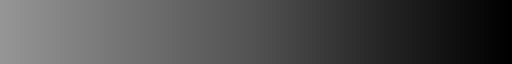

In [4]:
cmr.get_sub_cmap("Greys", 0.5, 1)

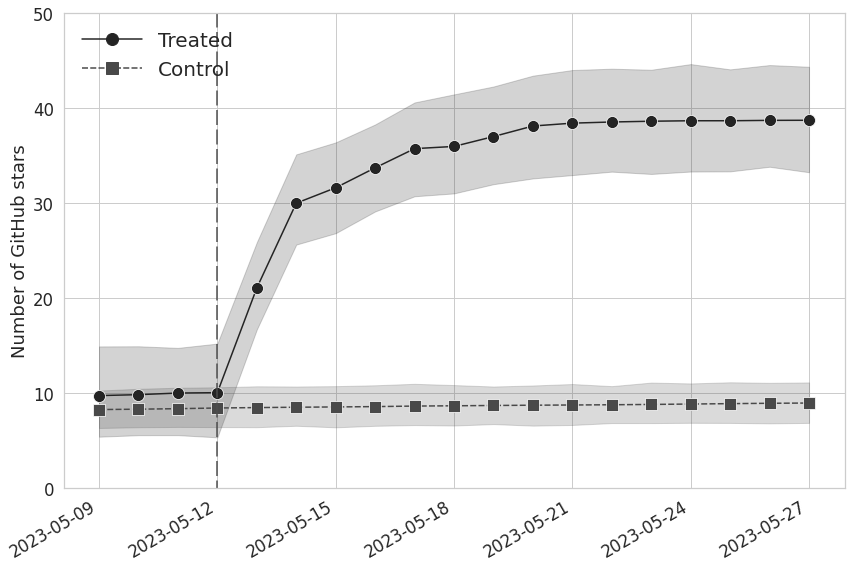

In [5]:
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df,
    x="date",
    y="stars",
    markersize=12,
    hue="treated",
    style="treated",
    hue_order=[1, 0],
    style_order=[1, 0],
    markers=["o", "s"],
    #     err_style="bars",
    ax=ax,
)

# Set the locator and formatter for the x-axis
myFmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)

# Specify the desired number of x-axis tickers
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

plt.xticks(rotation=30, ha="right")

# Add a vertical line to annotate a time period
annotate_date = pd.to_datetime("2023-05-12")  # Specify the date to annotate
plt.axvline(x=annotate_date, color=".3", linestyle=(5, (10, 3)))

# # Annotate a text on the plot
# annotate_date = pd.to_datetime('2023-05-15')  # Specify the date to annotate
# annotate_text = 'Annotated Text'  # Specify the text to annotate
# plt.annotate(annotate_text, xy=(annotate_date, 30), xytext=(10, 10),
#              textcoords='offset points', arrowprops=dict(arrowstyle='->'))

ax.set_yticks(range(0, 60, 10))

ax.set_ylabel("Number of GitHub stars")
ax.set_xlabel("")

# Legend
# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [0, 1]
labels = ["Treated", "Control"]
ax.legend(
    labels=[labels[idx] for idx in order],
    handles=[handles[idx] for idx in order],
    title="",
    loc="upper left",
    fontsize=20,
    markerscale=2,
    markerfirst=True,
    frameon=False,
    handlelength=3,
)

plt.tight_layout()

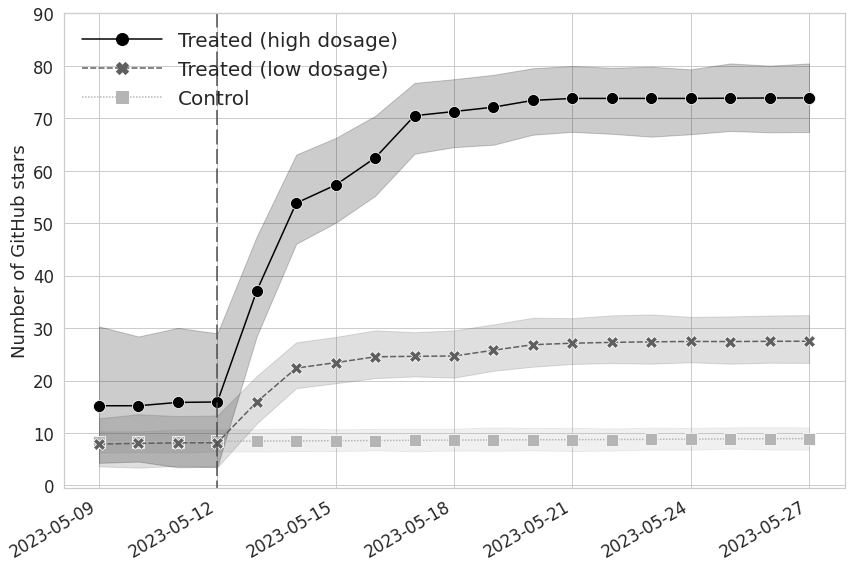

In [6]:
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df,
    x="date",
    y="stars",
    markersize=12,
    hue="treated2",
    style="treated2",
    hue_order=[2, 1, 0],
    style_order=[2, 1, 0],
    markers=["o", "X", "s"],
    palette=cmr.get_sub_cmap("Greys", 0.4, 1),
    #     err_style="bars",
    ax=ax,
)

# Set the locator and formatter for the x-axis
myFmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)

# Specify the desired number of x-axis tickers
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

plt.xticks(rotation=30, ha="right")

# Add a vertical line to annotate a time period
annotate_date = pd.to_datetime("2023-05-12")  # Specify the date to annotate
plt.axvline(x=annotate_date, color=".3", linestyle=(5, (10, 3)))

# # Annotate a text on the plot
# annotate_date = pd.to_datetime('2023-05-15')  # Specify the date to annotate
# annotate_text = 'Annotated Text'  # Specify the text to annotate
# plt.annotate(annotate_text, xy=(annotate_date, 30), xytext=(10, 10),
#              textcoords='offset points', arrowprops=dict(arrowstyle='->'))

ax.set_yticks(range(0, 100, 10))

ax.set_ylabel("Number of GitHub stars")
ax.set_xlabel("")

# Legend
# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [2, 1, 0]

# add legend to plot
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

labels = ["Control", "Treated (low dosage)", "Treated (high dosage)"]
ax.legend(
    labels=[labels[idx] for idx in order],
    handles=[handles[idx] for idx in order],
    title="",
    loc="upper left",
    fontsize=20,
    markerscale=2,
    markerfirst=True,
    frameon=False,
    handlelength=4,
)

plt.tight_layout()